<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/operanalyst/simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quite Complex Simulation

### Inevitable Imports

In [0]:
import scipy.integrate as integrate # for numerical solution od differential equations
import matplotlib.pyplot as plt     # for plots
import pandas as pd                 # for tables
import numpy as np                  # for matrices
import math as math

simulatedObjects = []

### Display functions 

,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16
5,5,25
6,6,36
7,7,49
8,8,64


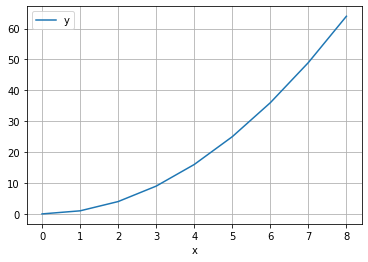

In [0]:
def displayData(data):
  display(pd.DataFrame(data))

def plotData(data, x = 0, y = 1, ax = None):
  df = pd.DataFrame(data)
  newax = None
  if ax is None:
    newax = df.plot.line(x = x, y = y)
  else:
    newax = df.plot.line(x = x, y = y, ax = ax)
  return newax

#=================#
# example of use  #
#=================#
#data = [(0, 0), (1, 1), (2, 4), (3, 9), (4, 16), (5, 25), (6, 36), (7, 49)]
data = [
  {'x': 0, 'y': 0}, {'x': 1, 'y': 1}, {'x': 2, 'y': 4},
  {'x': 3, 'y': 9}, {'x': 4, 'y': 16}, {'x': 5, 'y': 25},
  {'x': 6, 'y': 36}, {'x': 7, 'y': 49}, {'x': 8, 'y': 64},
]
plotData(data)
plt.grid(which='both')
displayData(data)

### Operators on Data Streams

In [0]:
def skip(generator, count):
  innerGen = iter(generator)
  for index in range(count):
    try:
        next(innerGen)
    except StopIteration:
        pass
  return innerGen

def take(generator, count):
  innerGen = iter(generator)
  for index in range(count):
    try:
        yield next(innerGen)
    except StopIteration:
        pass
  

def dilute(generator, ratio):
  innerGen = iter(generator)
  while True:
    skip(innerGen, ratio - 1)
    try:
        yield next(innerGen)
    except StopIteration:
        return

#=================#
# example of use  #
#=================#
data = [
  {'x': 0, 'y': 0}, {'x': 1, 'y': 1}, {'x': 2, 'y': 4},
  {'x': 3, 'y': 9}, {'x': 4, 'y': 16}, {'x': 5, 'y': 25},
  {'x': 6, 'y': 36}, {'x': 7, 'y': 49}, {'x': 8, 'y': 64},
]
partOfData = take(skip(data, 5), 2) # skip five, take two next, rest blow up
dilutedData = dilute(data, 2) # every odd
displayData(data)
displayData(partOfData)
displayData(dilutedData)


,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16
5,5,25
6,6,36
7,7,49
8,8,64


,x,y
0,5,25
1,6,36


,x,y
0,1,1
1,3,9
2,5,25
3,7,49


### Some Theory 
$\left( y=f(x)  \right)$

### Compute One Step function

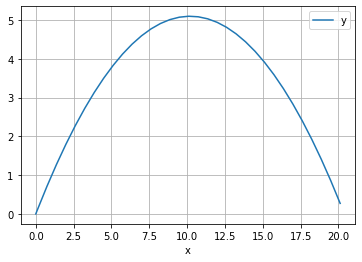

In [0]:
def compute(model, state0, t0 = 0.0, t_bound = 10, max_step = 0.0625):
  solver = integrate.RK45(fun = model, t0 = t0, y0 = state0, t_bound = t_bound, max_step = max_step)

  while True:
    message = solver.step()
    currentItem = {'time': solver.t, 'y': [*solver.y], 'yd': [*model(solver.t, solver.y)]}

    yield currentItem # send signal, inform about current result
    if (not(solver.status == 'running')):
        break
  return

#=================#
# example of use  #
#=================#
def model2D(time, state):
  velocity = state[:2]
  position = state[2:]
  acceleration = [0, -9.81]
  return [*acceleration, *velocity]

sim = compute(model2D, [10, 10, 0, 0])
result = []
for index, state in enumerate(sim):
  result.append(state)
  if index == 34: #magic number
    break

xy = list(map(lambda item: {'x': item['y'][2], 'y': item['y'][3]}, result))
plotData(xy)
plt.grid(which='both')

### Prepare and Simulate

In [0]:
def prepareSimulation(systemList, t0 = 0.0, t_bound = 10, max_step = 0.0625):
  for system in systemList:
    system['solver'] = compute(system['model'], system['state0'], t0 = t0, t_bound = t_bound, max_step = max_step)
    system['finished'] = False
    system['result'] = next(system['solver'])#system['state0']

def simulate(systemList):
  for system in systemList:
    if system['finished'] == False:
      system['result'] = next(system['solver'])

### Nearly Infinite Simulation

In [0]:
def simulateInf(systemList, count = -1):
  cc = count
  while True:
    simulate(systemList)
    partialResult = {}
    for system in systemList:
      partialResult[system['name']] = {**system}
    yield partialResult
    cc = cc - 1
    if cc == 0:
      break # maximum steps reached, break it


### Example of Single System Simulation

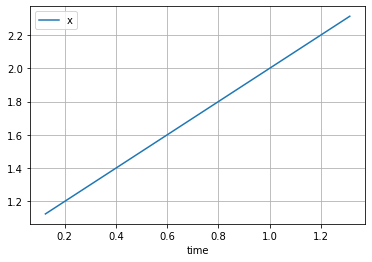

In [0]:
def movingObj(time, state):
  velocity = state[:3]
  position = state[3:]
  acceleration = [0, 0, 0]
  return [*acceleration, *velocity]

def rearangeResults(results, selectors):
  for result in results:
    partialResult = {}
    for selector in selectors:
      partialResult[selector['name']] = selector['selector'](result)
    yield partialResult

simulatedObjects = [{'state0': [1, 0.75, 0, 1, 1, 0], 'model': movingObj, 'name': 'obj1'}]
prepareSimulation(simulatedObjects)
simResults = list(simulateInf(simulatedObjects, 20))
simResultsRearanged = list(rearangeResults(simResults, 
  [
   {'name': 'time', 'selector': lambda item: item['obj1']['result']['time']},
   {'name': 'x', 'selector': lambda item: item['obj1']['result']['y'][3]},
   {'name': 'y', 'selector': lambda item: item['obj1']['result']['y'][4]}
   ]))

#simResults = list(justTwoFromResults(simResults, 'obj1', x = 3, y = 4))
#displayData(simResultsRearanged)
plotData(simResultsRearanged)#, x = 'x', y = 'y')
plt.grid(which='both')

### More Complex Simulation

#### Plane Model

In [0]:
def createPlaneModel(input):
  def planeModel(time, state):
    currentInput = input()
    
    currentVelocity = np.array(state[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array(state[3:])
    targetPosition = np.array(currentInput)

    wantedVelocity = targetPosition - currentPosition
    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector
    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs

    omegaOneVector = np.cross(currentVelocity / currentVelocityAbs, wantedVelocity / wantedVelocityAbs)
    accOneVector = np.cross(omegaOneVector, currentVelocity / currentVelocityAbs)

    neededAcceleration = wantedVelocity - currentVelocity
    neededAccelerationAbs = np.linalg.norm(neededAcceleration)
    neededAccelerationAbs = 3 * neededAccelerationAbs * currentVelocityAbs / wantedVelocityAbs

    neededAcceleration = neededAccelerationAbs * neededAcceleration

    result = [*neededAcceleration, *currentVelocity]
    return result
  return planeModel

#### Rocket Model

|symbol|meaning|
|-|-|
|$\vec r_r$ | missile to target destination |
|$\vec v_r$ | missile to target velocity |
| $n$ | control gain (3-5)|
|$\vec v_m$| absolute velocity of missile |


vector form of $\omega = \frac {v}{r}$

$\vec \omega = \frac {\vec r_r \times \vec v_r }{ \vec r_r \cdot \vec r_r }$

$\vec a = -n|\vec v_r|\frac{\vec v_m}{|\vec v_m|} \times \vec \omega$

centripetal acceleration $a=\omega \cdot v$ vector form $\vec a = -\vec v \times \vec \omega $

In [0]:
def createRocketModel(rocketSystem, systemToDestroy, n = 3):
  localData = {'rocket': rocketSystem, 'target': systemToDestroy}
  def rocketModel(time, state):
    if localData['rocket']()['finished']:
      return [0, 0, 0, 0, 0, 0]

    currentInput = localData['target']()['result']['y']

    currentPosition = np.array(state[3:])
    currentVelocity = np.array(state[:3])

    targetPosition = np.array(currentInput[3:])
    targetVelocity  = np.array(currentInput[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector

    positionR = targetPosition - currentPosition
    positionRAbs = np.linalg.norm(positionR) # abs of vector
    velocityR = targetVelocity - currentVelocity
    velocityRAbs = np.linalg.norm(velocityR) # abs of vector

    omega = 1 / positionRAbs / positionRAbs * np.cross(positionR, velocityR)

    neededAcceleration = -n * velocityRAbs / currentVelocityAbs * \
      np.cross(currentVelocity, omega)
    result = [*neededAcceleration, *currentVelocity]

    if positionRAbs < 1e0: # too close to target, eg. target hit
      #print('target', localData['target']())
      #print('rocket', localData['rocket']())
      #print('state', state)
      #print('currentInput', currentInput)
      localData['rocket']()['finished'] = True
      localData['target']()['finished'] = True
    #'''
    return result
  return rocketModel

"""
def createRocketModelAx02(rocketSystem, systemToDestroy, n = 1):
  localData = {'rocket': rocketSystem, 'target': systemToDestroy}
  def rocketModel(time, state):
    if localData['rocket']()['finished']:
      return [0, 0, 0, 0, 0, 0]

    currentInput = localData['target']()['result']['y']
    #print('currentInput', currentInput)
    currentVelocity = np.array(state[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array(state[3:])
    targetVelocity = np.array(currentInput[:3])
    targetPosition = np.array(currentInput[3:])


    relativeVelocity = currentVelocity - targetVelocity
    relativeVelocityAbs = np.linalg.norm(relativeVelocity)
    relativeDistance = currentPosition - targetPosition
    relativeDistanceAbs = np.linalg.norm(relativeDistance)
    timeToHit = relativeDistanceAbs / relativeVelocityAbs
    predictedTargetPosition = targetPosition + timeToHit * targetVelocity

    ####### !!!!!!!!!!!!!!! ###########
    wantedVelocity = predictedTargetPosition - currentPosition
    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector
    #'''
    if relativeDistanceAbs < 1e0: # too close to target, eg. target hit
      #print('target', localData['target']())
      #print('rocket', localData['rocket']())
      #print('state', state)
      #print('currentInput', currentInput)
      localData['rocket']()['finished'] = True
      localData['target']()['finished'] = True
    #'''
    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs
    neededAcceleration = wantedVelocity - currentVelocity

    result = [*(neededAcceleration * n), *currentVelocity]
    return result
  return rocketModel


def createRocketModel02(rocketSystem, systemToDestroy, n = 1):
  localData = {'rocket': rocketSystem, 'target': systemToDestroy}
  def rocketModel(time, state):
    if localData['rocket']()['finished']:
      return [0, 0, 0, 0, 0, 0]

    currentInput = localData['target']()['result']['y']
    #print('currentInput', currentInput)
    currentVelocity = np.array(state[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array(state[3:])
    targetVelocity = np.array(currentInput[:3])
    targetPosition = np.array(currentInput[3:])

    ####### !!!!!!!!!!!!!!! ###########
    wantedVelocity = targetVelocity + targetPosition - currentPosition

    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector
    #'''
    if wantedVelocityAbs < 1e0: # too close to target, eg. target hit
      #print('target', localData['target']())
      #print('rocket', localData['rocket']())
      #print('state', state)
      #print('currentInput', currentInput)
      localData['rocket']()['finished'] = True
      localData['target']()['finished'] = True
    #'''
    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs
    neededAcceleration = wantedVelocity - currentVelocity

    result = [*(neededAcceleration * n), *currentVelocity]
    return result
  return rocketModel



def createRocketModelOld(rocketSystem, systemToDestroy):
  localData = {'rocket': rocketSystem, 'target': systemToDestroy}
  def rocketModel(time, state):
    if localData['rocket']()['finished']:
      return [0, 0, 0, 0, 0, 0]

    currentInput = localData['target']()['result']['y']
    #print('currentInput', currentInput)
    currentVelocity = np.array(state[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array(state[3:])
    targetPosition = np.array(currentInput[3:])

    wantedVelocity = targetPosition - currentPosition
    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector
    #'''
    if wantedVelocityAbs < 1e0: # too close to target, eg. target hit
      #print('target', localData['target']())
      #print('rocket', localData['rocket']())
      #print('state', state)
      #print('currentInput', currentInput)
      localData['rocket']()['finished'] = True
      localData['target']()['finished'] = True
    #'''
    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs
    neededAcceleration = wantedVelocity - currentVelocity

    result = [*neededAcceleration, *currentVelocity]
    return result
  return rocketModel
"""

"\ndef createRocketModelAx02(rocketSystem, systemToDestroy, n = 1):\n  localData = {'rocket': rocketSystem, 'target': systemToDestroy}\n  def rocketModel(time, state):\n    if localData['rocket']()['finished']:\n      return [0, 0, 0, 0, 0, 0]\n\n    currentInput = localData['target']()['result']['y']\n    #print('currentInput', currentInput)\n    currentVelocity = np.array(state[:3])\n    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector\n    \n    currentPosition = np.array(state[3:])\n    targetVelocity = np.array(currentInput[:3])\n    targetPosition = np.array(currentInput[3:])\n\n\n    relativeVelocity = currentVelocity - targetVelocity\n    relativeVelocityAbs = np.linalg.norm(relativeVelocity)\n    relativeDistance = currentPosition - targetPosition\n    relativeDistanceAbs = np.linalg.norm(relativeDistance)\n    timeToHit = relativeDistanceAbs / relativeVelocityAbs\n    predictedTargetPosition = targetPosition + timeToHit * targetVelocity\n\n    ####### !!!!

In [0]:
def createFixedTarget(x, y, z):
  def fixedPoint():
    return [x, y, z]
  return fixedPoint

#### Simulation Output

,time,plane_x,plane_y,plane_z,plane_v,plane_f,rocket_x,rocket_y,rocket_z,rocket_v,rocket_f
0,0.034141,-2.529947,0.764396,998.089011,79.126950,False,528.405793,-499.244403,1.687996,250.000200,False
1,0.604157,0.209614,14.652521,963.368697,65.146560,False,674.741390,-478.187927,48.523997,250.000567,False
2,1.229157,11.266679,29.169313,927.076717,64.930705,False,786.866919,-430.949543,144.590051,250.000567,False
3,1.854157,23.858178,43.490066,891.274836,64.884515,False,842.606455,-360.709107,270.961619,250.000566,False
4,2.479157,37.129849,57.719069,855.702327,64.866980,False,832.578054,-276.336724,400.695688,250.000560,False
5,3.104157,50.796618,71.893408,820.266479,64.858329,False,764.862040,-188.922251,509.842518,250.000545,False
6,3.729157,64.726711,86.030743,784.923142,64.853354,False,657.437578,-106.590005,586.776548,250.000503,False
7,4.354157,78.847925,100.140926,749.647685,64.850185,False,527.664068,-32.676435,631.619261,250.000357,False
8,4.979157,93.116256,114.230034,714.424914,64.848015,False,387.393958,33.072148,650.826509,249.999481,False
9,5.604157,107.502865,128.302087,679.244784,64.846443,False,243.084131,92.802198,652.970467,249.977408,False


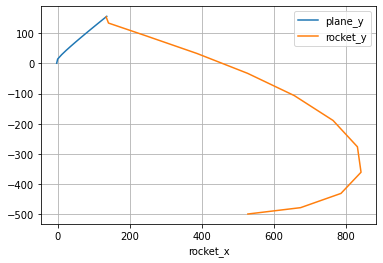

In [0]:
from math import sqrt

simulatedObjects = []
planeTarget = createFixedTarget(400, 400, 0)
plane = createPlaneModel(planeTarget)
rocket = createRocketModel(
    rocketSystem = lambda : simulatedObjects[1],
    systemToDestroy = lambda : simulatedObjects[0])

simulatedObjects = [
  {'state0': [-200, 0, 0, 0, 0, 1000], 'model': plane, 'name': 'plane'},
  {'state0': [250, 0, 0, 500, -500, 0], 'model': rocket, 'name': 'rocket'},
  ]

prepareSimulation(simulatedObjects, t0 = 0.0, t_bound = 2000, max_step = 0.0625)
simResults = list(dilute(simulateInf(simulatedObjects, 1000), 10))

ids = [
  {'name': 'time', 'selector': lambda item: item['plane']['result']['time']},
  {'name': 'plane_x', 'selector': lambda item: item['plane']['result']['y'][3]},
  {'name': 'plane_y', 'selector': lambda item: item['plane']['result']['y'][4]},
  {'name': 'plane_z', 'selector': lambda item: item['plane']['result']['y'][5]},

  {'name': 'plane_v', 'selector': lambda item: sqrt(
      item['plane']['result']['y'][0] * item['plane']['result']['y'][0] +
      item['plane']['result']['y'][1] * item['plane']['result']['y'][1] +
      item['plane']['result']['y'][2] * item['plane']['result']['y'][2])},

  {'name': 'plane_f', 'selector': lambda item: item['plane']['finished']},
  {'name': 'rocket_x', 'selector': lambda item: item['rocket']['result']['y'][3]},
  {'name': 'rocket_y', 'selector': lambda item: item['rocket']['result']['y'][4]},
  {'name': 'rocket_z', 'selector': lambda item: item['rocket']['result']['y'][5]},

  {'name': 'rocket_v', 'selector': lambda item: sqrt(
      item['rocket']['result']['y'][0] * item['rocket']['result']['y'][0] +
      item['rocket']['result']['y'][1] * item['rocket']['result']['y'][1] +
      item['rocket']['result']['y'][2] * item['rocket']['result']['y'][2])},

  {'name': 'rocket_f', 'selector': lambda item: item['rocket']['finished']},
  ]

reData = list(rearangeResults(simResults, ids))
toHitData = list(filter(lambda item: not item['plane_f'], reData))
displayData(toHitData)
ax = plotData(toHitData, x = 'plane_x', y = 'plane_y')
ax = plotData(toHitData, x = 'rocket_x', y = 'rocket_y', ax = ax)
plt.grid(which='both')

#### 3D Output

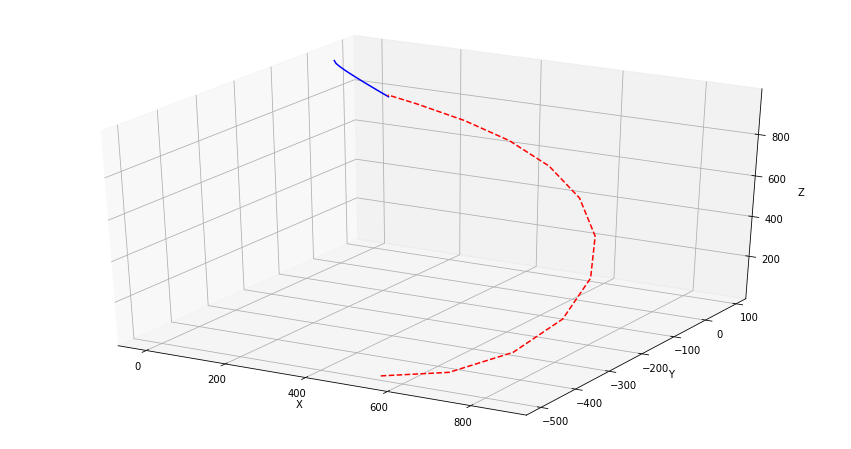

In [0]:
def selectValue(data, names):
  results = []
  for name in names:
    partialResult = []
    for item in data:
      partialResult.append(item[name])
    results.append(partialResult)
  return tuple(results)

plane_x, plane_y, plane_z = \
  selectValue(toHitData, ['plane_x', 'plane_y', 'plane_z'])
rocket_x, rocket_y, rocket_z = \
  selectValue(toHitData, ['rocket_x', 'rocket_y', 'rocket_z'])
gph = plt.figure(figsize=(15,8)).gca(projection='3d')
#plotting red dotted lines with tiny markers
gph.plot(plane_x, plane_y, plane_z, "b-")
gph.plot(rocket_x, rocket_y, rocket_z, "r--")
gph.set_xlabel('X')
gph.set_ylabel('Y')
gph.set_zlabel('Z')

plt.show()

### Three System Simulation

Rocket was not destroyed, plane was shooted down.

,time,plane_x,plane_y,plane_z,plane_f,rocket_x,rocket_y,rocket_z,rocket_f,antirocket_x,antirocket_y,antirocket_z,antirocket_f
0,0.211389,-14.324997,2.441212,999.755879,False,530.014485,-499.318817,1.417664,False,53.310276,0.001102,500.002392,False
1,0.523889,-27.202473,8.235605,999.176440,False,606.049413,-491.897148,16.876763,False,131.434789,0.085263,500.208629,False
2,0.836389,-36.607303,14.535598,998.546440,False,676.338636,-477.154944,47.234266,False,209.547527,0.514599,501.436731,False
3,1.148889,-44.173765,20.964868,997.903513,False,738.010458,-456.027380,90.040528,False,287.592975,1.440574,504.751782,False
4,1.461389,-50.536276,27.416217,997.258378,False,789.011396,-429.518722,142.771634,False,365.452022,2.630828,511.011462,False
5,1.773889,-56.024555,33.848031,996.615197,False,828.031327,-398.692936,202.884414,False,442.974143,3.266415,520.620948,False
6,2.086389,-60.837401,40.241950,995.975805,False,854.414445,-364.620141,267.931110,False,520.016078,1.678113,533.419886,False
7,2.398889,-65.106247,46.589564,995.341044,False,868.052607,-328.326567,335.654663,False,596.315210,-5.109547,548.622158,False
8,2.711389,-68.923656,52.887227,994.711277,False,869.274083,-290.757333,404.052245,False,670.744659,-22.076048,564.743933,False
9,3.023889,-72.357908,59.133739,994.086626,False,858.737768,-252.752151,471.410289,False,738.990945,-56.421555,579.543082,False


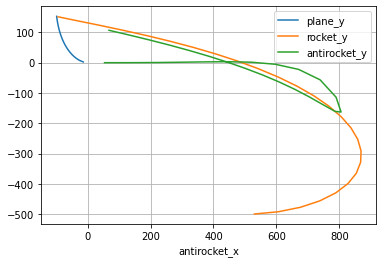

In [0]:
planeTarget = createFixedTarget(10000, 10000, 0)
plane = createPlaneModel(planeTarget)
rocketTarget = lambda : simulatedObjects[0]['state']['state'][3:] 
rocket = createRocketModel(
    rocketSystem = lambda : simulatedObjects[1], 
    systemToDestroy = lambda : simulatedObjects[0], 
    )
antiRocket = createRocketModel(
    rocketSystem = lambda : simulatedObjects[2], 
    systemToDestroy = lambda : simulatedObjects[1], 
    )

simulatedObjects = [
  {'state0': [-100, 0, 0, 0, 0, 1000], 'model': plane, 'name': 'plane'},
  {'state0': [250, 0, 0, 500, -500, 0], 'model': rocket, 'name': 'rocket'},
  {'state0': [250, 0, 0, 0, 0, 500], 'model': antiRocket, 'name': 'antiRocket'},
  ]

prepareSimulation(simulatedObjects, t0 = 0.0, t_bound = 1000, max_step = 0.03125)
simResults = list(dilute(simulateInf(simulatedObjects, 1000), 10))

ids = [
  {'name': 'time', 'selector': lambda item: item['plane']['result']['time']},
  {'name': 'plane_x', 'selector': lambda item: item['plane']['result']['y'][3]},
  {'name': 'plane_y', 'selector': lambda item: item['plane']['result']['y'][4]},
  {'name': 'plane_z', 'selector': lambda item: item['plane']['result']['y'][5]},
  {'name': 'plane_f', 'selector': lambda item: item['plane']['finished']},
  {'name': 'rocket_x', 'selector': lambda item: item['rocket']['result']['y'][3]},
  {'name': 'rocket_y', 'selector': lambda item: item['rocket']['result']['y'][4]},
  {'name': 'rocket_z', 'selector': lambda item: item['rocket']['result']['y'][5]},
  {'name': 'rocket_f', 'selector': lambda item: item['rocket']['finished']},
  {'name': 'antirocket_x', 'selector': lambda item: item['antiRocket']['result']['y'][3]},
  {'name': 'antirocket_y', 'selector': lambda item: item['antiRocket']['result']['y'][4]},
  {'name': 'antirocket_z', 'selector': lambda item: item['antiRocket']['result']['y'][5]},
  {'name': 'antirocket_f', 'selector': lambda item: item['antiRocket']['finished']},
  ]

reData = list(rearangeResults(simResults, ids))
#displayData(reData)
#ax = plotData(reData, x = 'plane_x', y = 'plane_y')
#ax = plotData(reData, x = 'rocket_x', y = 'rocket_y', ax = ax)
#ax = plotData(reData, x = 'antirocket_x', y = 'antirocket_y', ax = ax)

toHitData = list(filter(lambda item: not item['rocket_f'], reData))
displayData(toHitData)
ax = plotData(toHitData, x = 'plane_x', y = 'plane_y')
ax = plotData(toHitData, x = 'rocket_x', y = 'rocket_y', ax = ax)
ax = plotData(toHitData, x = 'antirocket_x', y = 'antirocket_y', ax = ax)
plt.grid(which='both')

#### 3D Plot

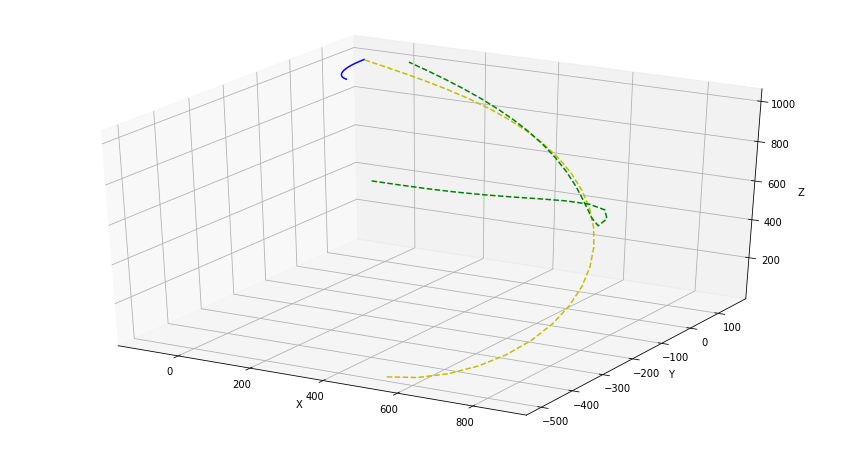

In [0]:
def selectValue(data, names):
  results = []
  for name in names:
    partialResult = []
    for item in data:
      partialResult.append(item[name])
    results.append(partialResult)
  return tuple(results)

plane_x, plane_y, plane_z = \
  selectValue(toHitData, ['plane_x', 'plane_y', 'plane_z'])
rocket_x, rocket_y, rocket_z = \
  selectValue(toHitData, ['rocket_x', 'rocket_y', 'rocket_z'])
antirocket_x, antirocket_y, antirocket_z = \
  selectValue(toHitData, ['antirocket_x', 'antirocket_y', 'antirocket_z'])

gph = plt.figure(figsize=(15,8)).gca(projection='3d')
#plotting red dotted lines with tiny markers
gph.plot(plane_x, plane_y, plane_z, "b-")
gph.plot(rocket_x, rocket_y, rocket_z, "y--")
gph.plot(antirocket_x, antirocket_y, antirocket_z, "g--")
gph.set_xlabel('X')
gph.set_ylabel('Y')
gph.set_zlabel('Z')

plt.show()

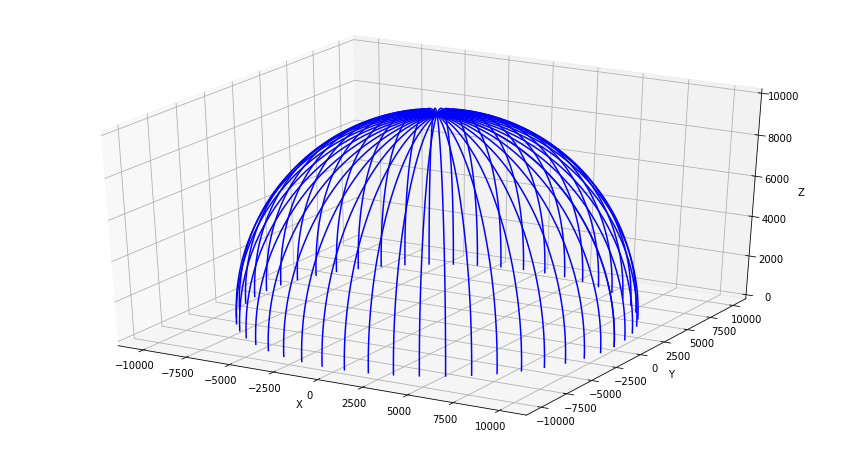

In [0]:
from math import pi, sin, cos

def angles(start, end, count = 50):
  delta = (end - start) / count
  for i in range(count + 1):
    yield start + i * delta

def segment(alpha, radius):
  for beta in angles(0, pi / 2):
    result = {
        'x': radius * cos(alpha) * cos(beta), 
        'y': radius * sin(alpha) * cos(beta),
        'z': radius * sin(beta),
        }
    #print(result)
    yield result

radius = 10000
gph = plt.figure(figsize=(15,8)).gca(projection='3d')
for alpha in angles(0, 2 * pi):
  s = list(segment(alpha, radius))
  x = list(map(lambda item: item['x'], s))
  y = list(map(lambda item: item['y'], s))
  z = list(map(lambda item: item['z'], s))
  gph.plot(x, y, z, "b-")
  #break

gph.set_xlabel('X')
gph.set_ylabel('Y')
gph.set_zlabel('Z')

plt.show()


In [0]:
import folium

m = folium.Map(
    location=[49.1687516,16.6725822],
    zoom_start=13,
    tiles='Stamen Terrain'
)

urlhead = 'http://services.arcgisonline.com/arcgis/rest/services'
urltail = '/MapServer/tile/{z}/{y}/{x}'
maps = {
#  'World_Ocean_Base': '/Ocean/World_Ocean_Base',
#  'World_Navigation_Charts': '/Specialty/World_Navigation_Charts',
#  'World_Ocean_Reference': '/Ocean/World_Ocean_Reference',
#  'NatGeo_World_Map': '/NatGeo_World_Map/MapServer',
  'World_Imagery': '/World_Imagery/MapServer',
#  'World_Physical_Map': '/World_Physical_Map/MapServer',
  'World_Shaded_Relief': '/World_Shaded_Relief/MapServer',
  'World_Street_Map': '/World_Street_Map/MapServer',
#  'World_Terrain_Base': '/World_Terrain_Base/MapServer',
  'World_Topo_Map': '/World_Topo_Map/MapServer'
}

for tile_name, tile_url in maps.items():
  wl = folium.WmsTileLayer(url = urlhead + tile_url + urltail, name = tile_name, show = False)
  wl.add_to(m)


folium.LayerControl().add_to(m)
fs = folium.plugins.Fullscreen()
m.add_child(fs)

tooltip = 'Click me!'
folium.Marker([45.3288, -121.6625], popup='<i>Mt. Hood Meadows</i>', tooltip=tooltip).add_to(m)

points = [[49.1687516,16.6725822], [49.1687516,16.8]]
folium.PolyLine(locations = points, color="red", weight=2.5, opacity=0.8, popup = '<i>Linie :)</i>', tooltip = tooltip).add_to(m)

m

# Sim Composer

In [0]:
def systemA(t, state):
  return [0, 0, 0, *state[:3]] # nezrychlujici, tj. konstantni rychlost
def systemB(t, state):
  return [0, 0, -9.81, *state[:3]] # pohyb v gravitacnim poli

systemA0 = [100, 0, 0, 0, 0, 1000]
systemB0 = [100, 0, 100, 0, 0, 0]

def compose(systemList, state0List):
  
  def result(t, state):
    dstate = []
    index = 0
    start = 0
    end = len(state0List[index])
    for system, state0  in zip(state0List, systemList):

    return state
  return result